In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

2024-02-13 13:42:46.698152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

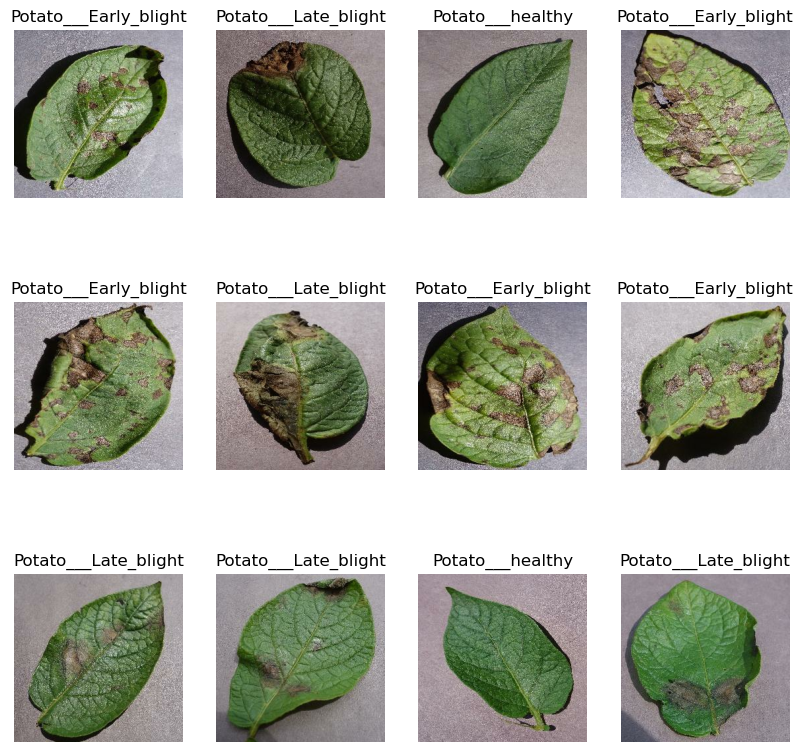

In [6]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle = True, shuffle_size=100000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(test_size)
    
    return train_ds, test_ds, val_ds
    

In [8]:
train_ds, test_ds, val_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

54

In [10]:
len(test_ds)

6

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(), 
    layers.Dense(64, activation = 'relu'),
    layers.Dense(3, activation='softmax')
])

model.build(input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [16]:
model.compile(
    optimizer = "adam", 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE, 
    verbose=1,
    validation_data = val_ds
)

Epoch 1/20
54/54 [==============================] - 167s 3s/step - loss: 0.8790 - accuracy: 0.5527 - val_loss: 0.7342 - val_accuracy: 0.6667
Epoch 2/20
54/54 [==============================] - 152s 3s/step - loss: 0.5745 - accuracy: 0.7546 - val_loss: 0.5891 - val_accuracy: 0.6875
Epoch 3/20
54/54 [==============================] - 164s 3s/step - loss: 0.3088 - accuracy: 0.8802 - val_loss: 0.2219 - val_accuracy: 0.9115
Epoch 4/20
54/54 [==============================] - 138s 2s/step - loss: 0.2448 - accuracy: 0.9062 - val_loss: 0.3873 - val_accuracy: 0.8177
Epoch 5/20
54/54 [==============================] - 141s 3s/step - loss: 0.2449 - accuracy: 0.9034 - val_loss: 0.1638 - val_accuracy: 0.9323
Epoch 6/20
54/54 [==============================] - 135s 2s/step - loss: 0.1284 - accuracy: 0.9531 - val_loss: 0.4019 - val_accuracy: 0.8646
Epoch 7/20
54/54 [==============================] - 124s 2s/step - loss: 0.1504 - accuracy: 0.9444 - val_loss: 0.1457 - val_accuracy: 0.9479
Epoch 8/20
54

In [18]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 10s 628ms/step - loss: 0.0165 - accuracy: 0.9948


In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

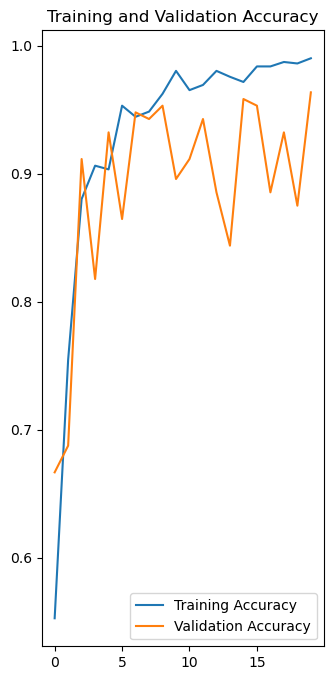

In [21]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label ="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

actual label: Potato___healthy
1/1 [==============================] - 0s 438ms/step
predicted label: Potato___healthy


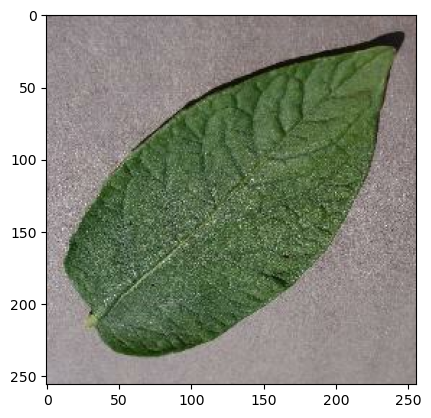

In [25]:
for image_batch, labels_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.imshow(first_image)
    print("actual label:", class_name[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label:", class_name[np.argmax(batch_prediction[0])])

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    
    predicted_class = class_name[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


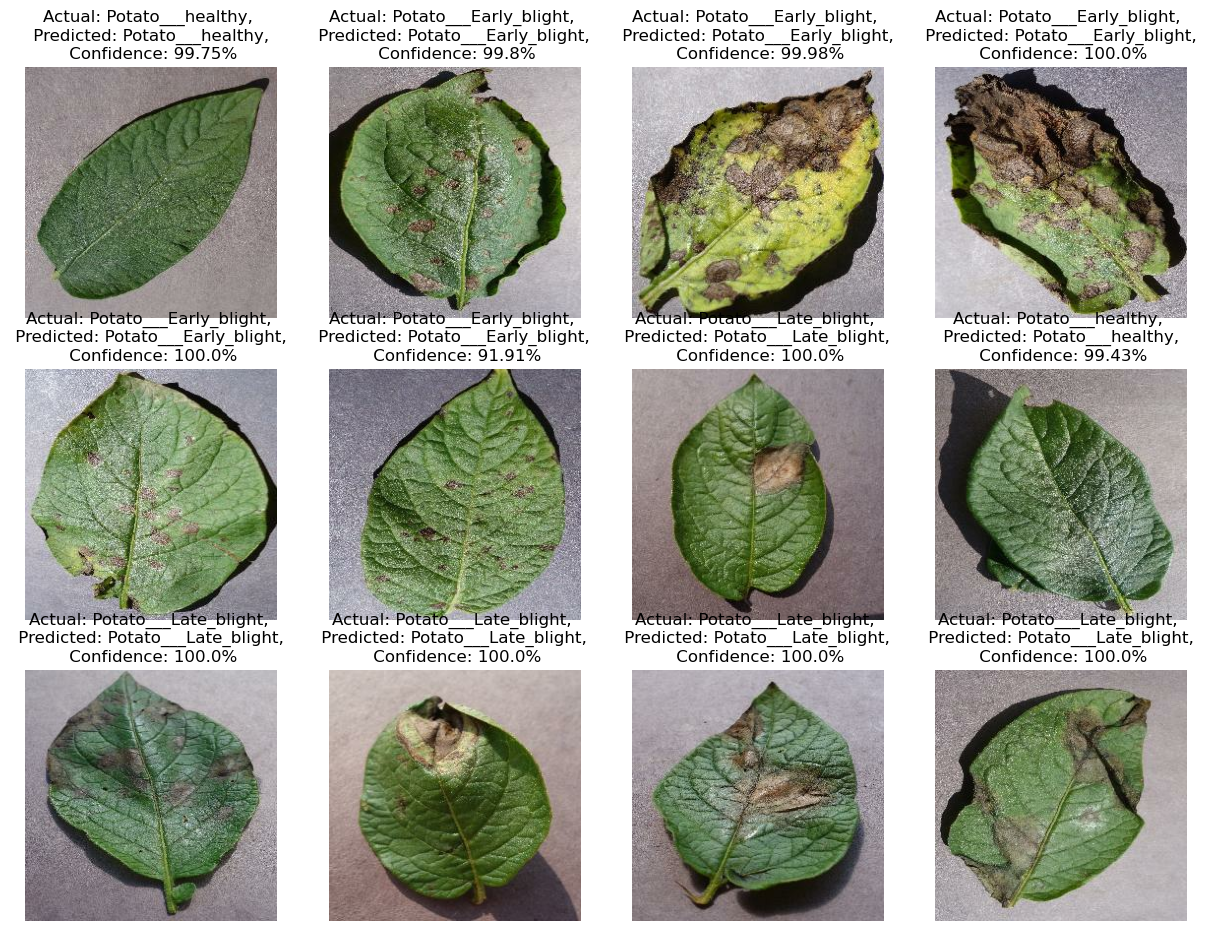

In [32]:
plt.figure(figsize = (15,15))
for images, labels, in test_ds.take(1):
    for i in range(12):
        
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")

In [35]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2/assets


INFO:tensorflow:Assets written to: ../models/2/assets
